# Anomaly Detection

In this part will look at the anomaly detection built by CoScale and how you can build yourself.

## 1. Load Data

First we will load the data using a [pickle format](https://docs.python.org/2/library/pickle.html).

The data we use contains the pageviews of one of our own websites and for convenience there is only 1 data point per hour.

In [1]:
import pickle

past = pickle.load(open('release/1/data/past_data.pickle', 'rb'), encoding='latin1')
all_data = pickle.load(open('release/1/data/all_data.pickle', 'rb'), encoding='latin1')


## 2. Plot past data

To plot the past data we will use ```matplotlib.pyplot```. For convenience we import it as ```plt```. 

```% matplotlib inline``` makes sure you can see the output in the notebook. 

(Use ```% matplotlib notebook``` if you want to make it ineractive. Don't forget to click the power button to finish the interaction and to be able to plot a new figure.)

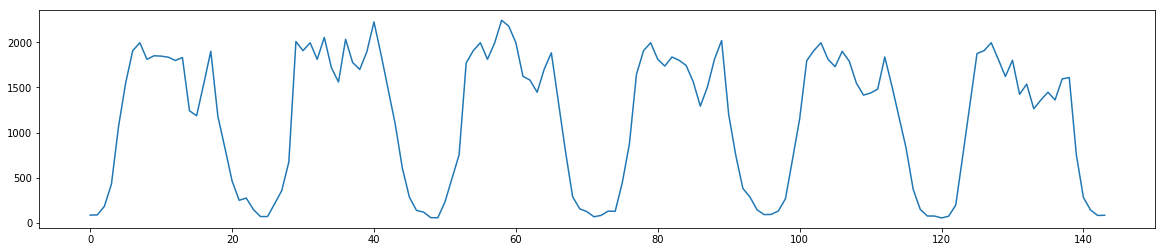

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4)) # This creates a new figure with the dimensions of 20 by 4
plt.plot(past)             # This creates the actual plot
plt.show()                 # This shows the plot

## 3. Find the minimum and maximum

Use [```np.nanmax()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmax.html#numpy.nanmax) and [```np.nanmin()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmin.html) to find the minmum and maximum while ignoring the NaNs.

In [4]:
import numpy as np

In [7]:
##### Implement this part of the code #####
maximum = past.max()
minimum = past.min()
print(minimum, maximum)

55.031140716069935 2243.668519805421


And plot these together with the data using the [```plt.axhline()```](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.axhline) function.

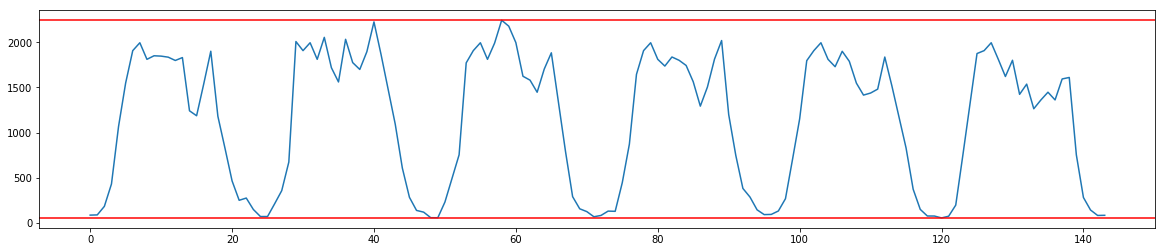

In [8]:
plt.figure(figsize=(20,4))
plt.plot(past)
plt.axhline(maximum, color='r')
plt.axhline(minimum, color='r')
plt.show()

## 4. Testing the model on unseen data

Now plot all the data instead of just the past data

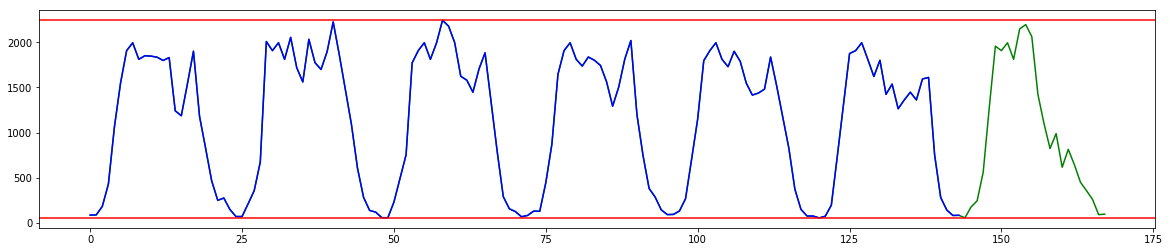

In [9]:
plt.figure(figsize=(20,4))
plt.plot(all_data, color='g')
plt.plot(past, color='b')
plt.axhline(maximum, color='r')
plt.axhline(minimum, color='r')
plt.show()

You can clearly see now  that this model does not detect any anomalies. However, the last day of data clearly looks different compared to the other days.

In what follows we will build a better model for anomaly detection that is able to detect these 'shape shifts' as well.

## 5. Building a model with seasonality

To do this we are going to take a step by step approach. Maybe it won't be clear at first why every step is necessary, but that will become clear throughout the process.

First we are going to reshape the past data to a 2 dimensional array with 24 columns. This will give us 1 row for each day and 1 column for each hour. For this we are going to use the [```np.reshape()```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) function. The newshape parameter is a tuple which in this case should be ```(-1, 24)```. If you use a ```-1``` the reshape function will automatically compute that dimension. Pay attention to the order in which the numbers are repositonned (the default ordering should work fine here).

In [11]:
##### Implement this part of the code #####
reshaped_past = past.reshape((-1, 24))

assert len(reshaped_past.shape) == 2
assert reshaped_past.shape[1] == 24

Now we are going to compute the average over all days. For this we are going to use the [```np.mean()```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) with the axis variable set to the first dimension (```axis=0```). Next we are going to plot this.

(24,)


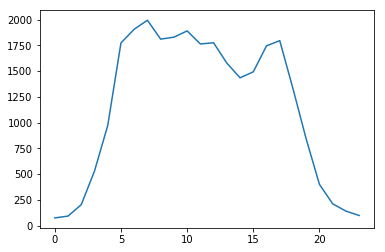

In [19]:
##### Implement this part of the code #####
average_past = np.mean(reshaped_past, axis=0)

print(average_past.shape)

assert average_past.shape == (24,)

plt.plot(average_past)
plt.show()

What you can see in the plot above is the average number of pageviews for eacht hour of the day.

Now let's plot this together with the past data on 1 plot. Use a [for loop](https://wiki.python.org/moin/ForLoop) and the [```np.concatenate()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) function to concatenate this average 6 times into the variable ```model```.

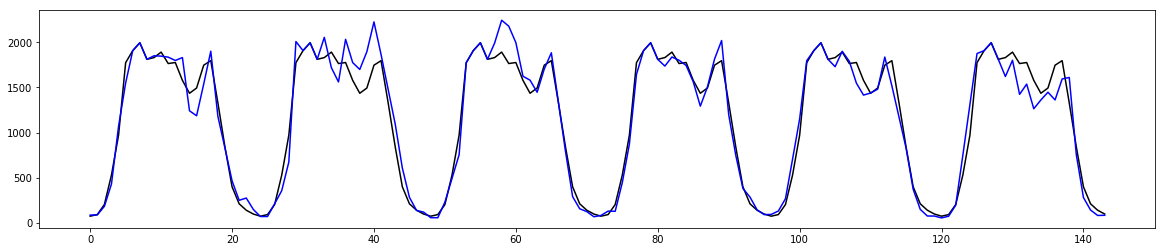

In [21]:
model = []
for i in range(6):
    model = np.concatenate((model, average_past), axis=0)

plt.figure(figsize=(20,4))    
plt.plot(model, color='k')
plt.plot(past, color='b')
plt.show()

In the next step we are going to compute the maximum (= positive) and minimum (= negative) deviations from the average to determine what kind of deviations are normal. (Just substract the average/model from the past and take the min and the max of that)

In [23]:
##### Implement this part of the code #####
deviations = past - model
delta_min = deviations.min()
delta_max = deviations.max()
print(delta_min, delta_max)

-384.55238276021805 479.3687377717854


Now let's plot this.

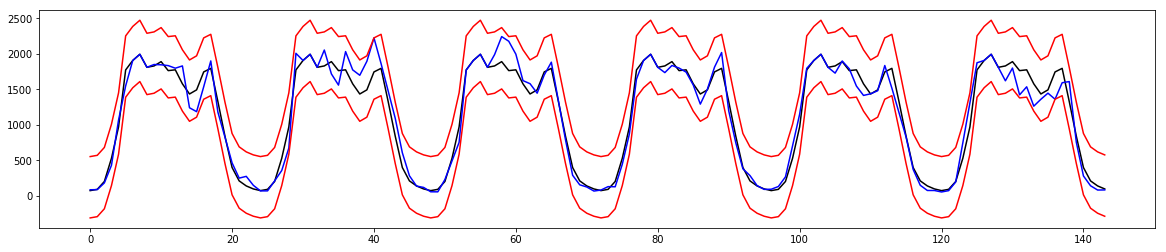

In [24]:
plt.figure(figsize=(20,4))
plt.plot(model, color='k')
plt.plot(past, color='b')
plt.plot(model + delta_max, color='r')
plt.plot(model + delta_min, color='r')
plt.show()

Now let's test this on all data

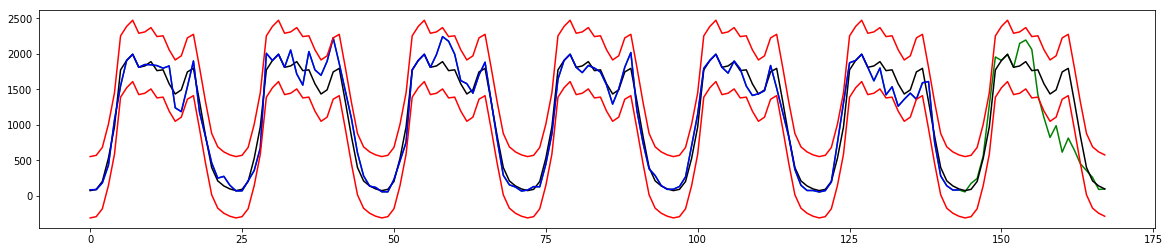

In [25]:
model_all = np.concatenate((model, average_past))

plt.figure(figsize=(20,4))
plt.plot(all_data, color='g')
plt.plot(model_all, color='k')
plt.plot(past, color='b')
plt.plot(model_all + delta_max, color='r')
plt.plot(model_all + delta_min, color='r')
plt.show()

Now you can clearly see where the anomaly is detected by this more advanced model. The code below can gives you the exact indices where an anomaly is detected. The functions uses are the following [```np.where()```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) and [```np.logical_or()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.logical_or.html).

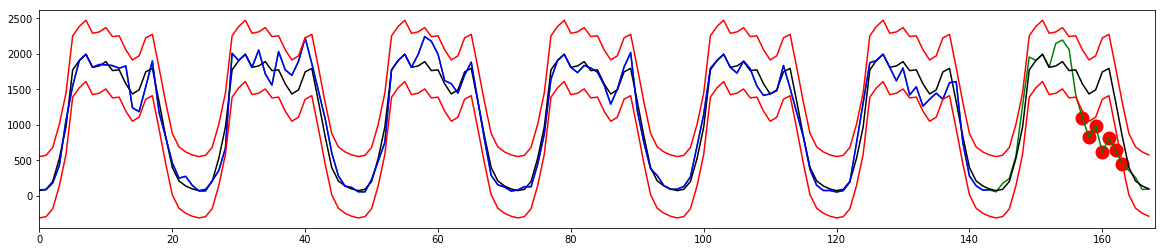

The anomaly occurs at the following timestamps: [157 158 159 160 161 162 163]


In [26]:
anomaly_timepoints = np.where(np.logical_or(all_data < model_all + delta_min, all_data > model_all + delta_max))[0]

plt.figure(figsize=(20,4))
plt.scatter(anomaly_timepoints, all_data[anomaly_timepoints], color='r', linewidth=8)
plt.plot(all_data, color='g')
plt.plot(model_all, color='k')
plt.plot(past, color='b')
plt.plot(model_all + delta_max, color='r')
plt.plot(model_all + delta_min, color='r')
plt.xlim(0, len(all_data))
plt.show()

print('The anomaly occurs at the following timestamps:', anomaly_timepoints)